In [5]:
###########################################################################     
############################ model training ###############################
###########################################################################
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns



inp = input('Are you compiling on google colab?, y/n: ')
if inp.lower() == "y":
    print("We are using google colab")
    ############## if compile on google colab #################
    !pip install import-ipynb
    import import_ipynb

    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    your_module = drive.CreateFile({'id':'1G1d25XyvC2ZdqfHBDCYkHgXIqgdK7PFk'})
    # https://drive.google.com/open?id=1wCNx7SWrCPL78UmmzEF6pAfdniCVJUWS
    # https://drive.google.com/open?id=1WtBoScDx5eMdQKYwLAkUbpJyYUxrNFGw
    # https://drive.google.com/open?id=1UmFmSi9bU_uhArlFyVBz1SDiASMR67Gx
    # https://drive.google.com/open?id=1G1d25XyvC2ZdqfHBDCYkHgXIqgdK7PFk
    your_module.GetContentFile('data_utils.ipynb')
    
    import data_utils as data_utils
    data_utils.unzip("./data-merged.zip")
    
    
    folders = ["./data/"]
    data_utils.create_folders(folders)
    data_utils.move_folder("./data-merged/", "./data")
    path = Path(os.getcwd())/"data"
    tfms = get_transforms(do_flip=True, flip_vert=True)
    data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)
    
elif inp.lower() == "n":
    import data_utils as data_utils
    print("We are using local machine")
    ########## if compile locally ###############
    
    data_utils.unzip("/content/drive/My Drive/data-merged.zip")
    path = Path(os.getcwd())/"data"
    tfms = get_transforms(do_flip=True, flip_vert=True)
    data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)
else:
    print("Please reply y/n")
    
    


from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import confusion_matrix

Are you compiling on google colab?, y/n: Y
We are using google colab
Do you clear the folder ./data/?, y/n: Y
The folder will be cleared


In [3]:
!ls

adc.json  data-merged	   data_utils.ipynb  processed_data
data	  data-merged.zip  __MACOSX	     sample_data


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


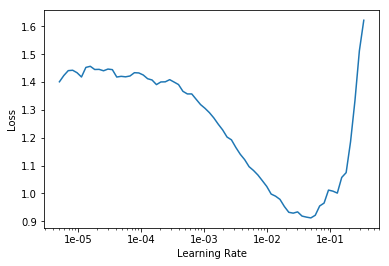

In [6]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

learn.model

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(20,max_lr=3.9e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.585715,0.311120,0.109127,01:01
1,0.316104,0.230264,0.075397,00:56
2,0.252062,0.196321,0.063492,00:58
3,0.252374,0.220360,0.069444,01:02
4,0.237260,0.313675,0.113095,00:59
5,0.253213,0.178323,0.057540,00:59
6,0.225436,0.168584,0.061508,00:59
7,0.206997,0.163167,0.049603,00:59
8,0.228263,0.194074,0.061508,01:00
9,0.149945,0.149748,0.047619,00:58


In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

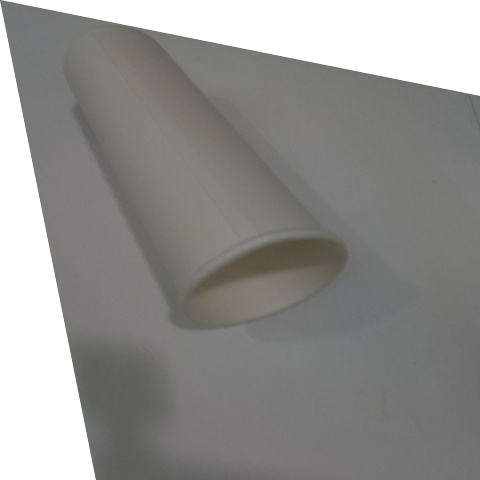

In [11]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [13]:
data.test_ds.items[200]

PosixPath('/content/data/test/trash/trash59.jpg')

In [20]:
## predicted values
print(yhat[95:105])
## actual values
print(y[95:105])

['recycle', 'recycle', 'recycle', 'recycle', 'recycle', 'recycle', 'compost', 'compost', 'recycle', 'recycle']
['compost', 'compost', 'compost', 'compost', 'compost', 'compost', 'compost', 'compost', 'compost', 'compost']


In [15]:

cm = confusion_matrix(y,yhat)
print(cm)

[[ 37 101   8]
 [ 41 162   0]
 [ 32  66   2]]


In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [17]:
accuracy = correct/sum(sum(cm))
accuracy

0.44766146993318484

In [18]:
############## error analysis ###############
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.most_confused(min_val=2)

[('recycle', 'compost', 4),
 ('trash', 'recycle', 4),
 ('compost', 'trash', 3),
 ('trash', 'compost', 3)]